In [284]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor as RFR
from xgboost import XGBRegressor as XGBR
from lightgbm import LGBMRegressor as LGBMR

In [285]:
# Import file
data=pd.read_csv('fifa21_train.csv')
data.shape

(11701, 101)

In [286]:
# Standardize headers

def standardize_header(dataframe):
    dataframe.columns = [c.lower().replace(' ', '_') for c in dataframe.columns]

standardize_header(data)

In [287]:
# Drop duplicate columns

def drop_duplicate_columns(dataframe):
    return dataframe.loc[:,~dataframe.T.duplicated(keep='first')]

data = drop_duplicate_columns(data)
data.shape

(11701, 85)

In [288]:
# Standardize headers kept after drop of duplicate columns

def map_columns(dataframe):
    col_mapping = {
        'ls':'striker',
        'lw':'wing',
        'lf':'forward',
        'lam':'att_mid',
        'lm':'side_mid',
        'lcm':'center_mid',
        'lwb':'back_wing',
        'ldm':'def_wing',
        'lb':'def_laterals',
        'lcb':'center_back'
    }
    return dataframe.rename(columns = col_mapping)

data = map_columns(data)

In [289]:
# Drop useless columns

def drop_useless_cols(dataframe):
    return dataframe.drop(columns=[
        'id', 'name', 'age', 'nationality', 'club', 'position', 'team_&_contract', 'joined', 'loan_date_end', 
        'value', 'wage', 'release_clause', 'contract', 
        
        # Trying to remove highly correlated columns
        'ir',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 
        'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 
        'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
        'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'composure',
        'marking', 'standing_tackle', 'sliding_tackle',
        'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'
    ], axis=1)
    
data = drop_useless_cols(data)
data.shape

(11701, 37)

In [290]:
# Convert 'height' into cm

def convert_into_cm(dataframe):
    dataframe['height'] = dataframe['height'].str.replace("'", '.').str.replace('"', '').astype(float)
    dataframe['height'] = round(dataframe['height'] * 30.48, 1)

convert_into_cm(data)

In [291]:
# Convert 'weight' into kg

def convert_int_kg(dataframe):
    dataframe['weight'] = dataframe['weight'].str.replace('lbs', '').astype(float)
    dataframe['weight'] = round(dataframe['weight'] * 0.453592, 1)

convert_int_kg(data)

In [292]:
# Standardize 'foot'

def standardize_foot(dataframe):
    dataframe['foot'] = dataframe['foot'].map(dict(Left=0, Right=1))
    
standardize_foot(data)

In [293]:
# Fill nan values for 'volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle', 'interceptions', 'positioning', 'composure'

def fill_nan_subset_mean(dataframe):
    column_names = ['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle', 'interceptions', 'positioning', 'composure']
    for column in column_names:
        bp_list = dataframe[dataframe[column].isna()]['bp'].unique()
        for bp in bp_list:
            mean = round(dataframe[dataframe['bp'] == bp][column].mean(), 1)
            subset_filter = (dataframe[column].isna()) & (dataframe['bp'] == bp)
            dataframe.loc[subset_filter, column] = mean
    
    return dataframe

#data = fill_nan_subset_mean(data)

In [294]:
# Fill nan values for 'a/w' & 'd/w'

def fill_nan_subset_mode(dataframe):
    column_names = ['a/w', 'd/w']
    for column in column_names:
        bp_list = dataframe[dataframe[column].isna()]['bp'].unique()
        for bp in bp_list:
            mode = dataframe[dataframe['bp'] == bp][column].mode()[0]
            subset_filter = (dataframe[column].isna()) & (dataframe['bp'] == bp)
            dataframe.loc[subset_filter, column] = mode
            
    return dataframe
            
data = fill_nan_subset_mode(data)

In [295]:
# Replace 'a/w' & 'd/w' with int values

def map_string_into_int(dataframe):
    column_names = ['a/w', 'd/w']
    for col in column_names:
        dataframe[col] = dataframe[col].map(dict(Low=0, Medium=1, High=2))
        
map_string_into_int(data)

In [296]:
# Remove stars in 'w/f', 'sm' & 'ir'

def remove_stars(dataframe):
    #column_names = ['w/f', 'sm', 'ir']
    column_names = ['w/f', 'sm']
    for column in column_names:
        dataframe[column] = dataframe[column].str.replace('★', '').str.replace(' ', '').astype(int)
        
remove_stars(data)

In [297]:
# Standardize 'hits'

def internal_standardize_hits(x):
    if type(x) == int:
        return x
    elif 'K' in x:
        return int(float(x.replace('K', '')) * 1000)
    else:
        return int(x)
    
def standardize_hits(dataframe):
    dataframe['hits'] = dataframe['hits'].apply(internal_standardize_hits)

standardize_hits(data)

In [298]:
# Evaluate 'striker', 'wing', 'forward', 'att_mid', 'side_mid', 'center_mid', 'back_wing', 'def_wing', 'def_laterals', 'center_back', 'gk'

def evaluate_columns(dataframe):
    column_names = ['striker', 'wing', 'forward', 'att_mid', 'side_mid', 'center_mid', 'back_wing', 'def_wing', 'def_laterals', 'center_back', 'gk']
    for col in column_names:
        dataframe[col] = dataframe[col].apply(eval)

evaluate_columns(data)

In [299]:
# Check nan values

def check_nan_values(dataframe):
    for c in dataframe.columns:
        print(f'{c} : {dataframe[c].isna().sum()}')
        
check_nan_values(data)

bp : 0
height : 0
weight : 0
foot : 0
growth : 0
attacking : 0
skill : 0
movement : 0
power : 0
mentality : 0
defending : 0
goalkeeping : 0
total_stats : 0
base_stats : 0
w/f : 0
sm : 0
a/w : 0
d/w : 0
pac : 0
sho : 0
pas : 0
dri : 0
def : 0
phy : 0
hits : 0
striker : 0
wing : 0
forward : 0
att_mid : 0
side_mid : 0
center_mid : 0
back_wing : 0
def_wing : 0
def_laterals : 0
center_back : 0
gk : 0
ova : 0


In [300]:
# Check columns type

def check_columns_type(dataframe):
    for c in dataframe.columns:
        print(f'{c} : {dataframe[c].dtypes}')
        
check_columns_type(data)

bp : object
height : float64
weight : float64
foot : int64
growth : int64
attacking : int64
skill : int64
movement : int64
power : int64
mentality : int64
defending : int64
goalkeeping : int64
total_stats : int64
base_stats : int64
w/f : int64
sm : int64
a/w : int64
d/w : int64
pac : int64
sho : int64
pas : int64
dri : int64
def : int64
phy : int64
hits : int64
striker : int64
wing : int64
forward : int64
att_mid : int64
side_mid : int64
center_mid : int64
back_wing : int64
def_wing : int64
def_laterals : int64
center_back : int64
gk : int64
ova : int64


In [301]:
data=pd.read_csv('fifa21_train.csv')

def preprocess(dataframe):
    # Standardize headers
    standardize_header(dataframe)
    
    # Drop duplicate columns
    dataframe = drop_duplicate_columns(dataframe)
    
    # Standardize headers kept after drop of duplicate columns
    dataframe = map_columns(dataframe)
    
    # Drop useless columns
    dataframe = drop_useless_cols(dataframe)
    
    # Convert 'height' into cm
    convert_into_cm(dataframe)
    
    # Convert 'weight' into kg
    convert_int_kg(dataframe)
    
    # Standardize 'foot'
    standardize_foot(dataframe)
    
    # Fill nan values for 'volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle', 'interceptions', 'positioning', 'composure'
    #dataframe = fill_nan_subset_mean(dataframe)
    
    # Fill nan values for 'a/w' & 'd/w'        
    dataframe = fill_nan_subset_mode(dataframe)
    
    # Replace 'a/w' & 'd/w' with int values    
    map_string_into_int(dataframe)
    
    # Remove stars in 'w/f', 'sm' & 'ir'    
    remove_stars(dataframe)
    
    # Standardize 'hits'
    standardize_hits(dataframe)
    
    # Evaluate 'striker', 'wing', 'forward', 'att_mid', 'side_mid', 'center_mid', 'back_wing', 'def_wing', 'def_laterals', 'center_back', 'gk'
    evaluate_columns(dataframe)
    
    return dataframe

data = preprocess(data)

# Check nan values
print('==> NaN value check <==')
check_nan_values(data)
print('=========================')

# Check columns type
print('==> Column type check <==')
check_columns_type(data)
print('=========================')

data.to_csv('fifa21_train_cleaned.csv')

==> NaN value check <==
bp : 0
height : 0
weight : 0
foot : 0
growth : 0
attacking : 0
skill : 0
movement : 0
power : 0
mentality : 0
defending : 0
goalkeeping : 0
total_stats : 0
base_stats : 0
w/f : 0
sm : 0
a/w : 0
d/w : 0
pac : 0
sho : 0
pas : 0
dri : 0
def : 0
phy : 0
hits : 0
striker : 0
wing : 0
forward : 0
att_mid : 0
side_mid : 0
center_mid : 0
back_wing : 0
def_wing : 0
def_laterals : 0
center_back : 0
gk : 0
ova : 0
==> Column type check <==
bp : object
height : float64
weight : float64
foot : int64
growth : int64
attacking : int64
skill : int64
movement : int64
power : int64
mentality : int64
defending : int64
goalkeeping : int64
total_stats : int64
base_stats : int64
w/f : int64
sm : int64
a/w : int64
d/w : int64
pac : int64
sho : int64
pas : int64
dri : int64
def : int64
phy : int64
hits : int64
striker : int64
wing : int64
forward : int64
att_mid : int64
side_mid : int64
center_mid : int64
back_wing : int64
def_wing : int64
def_laterals : int64
center_back : int64
gk : i

In [302]:
# Get categorical columns

cat_cols=[col for col in data.columns if (data[col].dtype==object)]

In [303]:
# Get numerical columns

num_cols=[c for c in data.columns if (data[c].dtype!=object)]

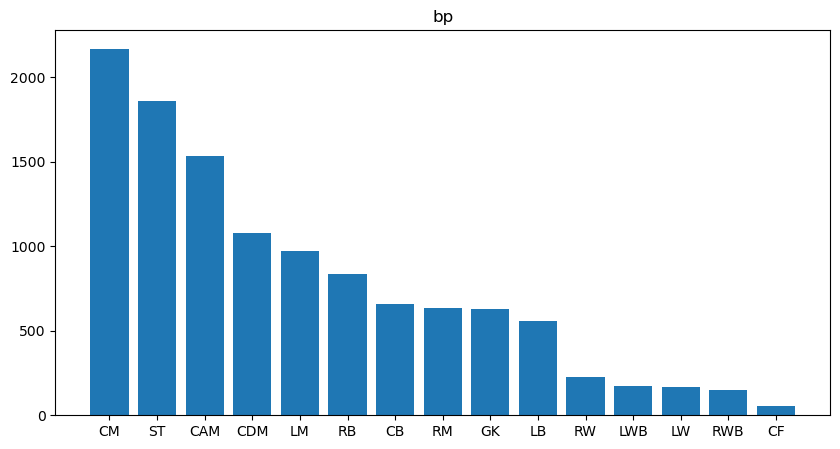

In [304]:
# Show bar plot on categorical data

for c in cat_cols:
    plt.figure(figsize=(10,5))
    plt.bar(data[c].unique(), data[c].value_counts())
    plt.title(c)
    plt.show();

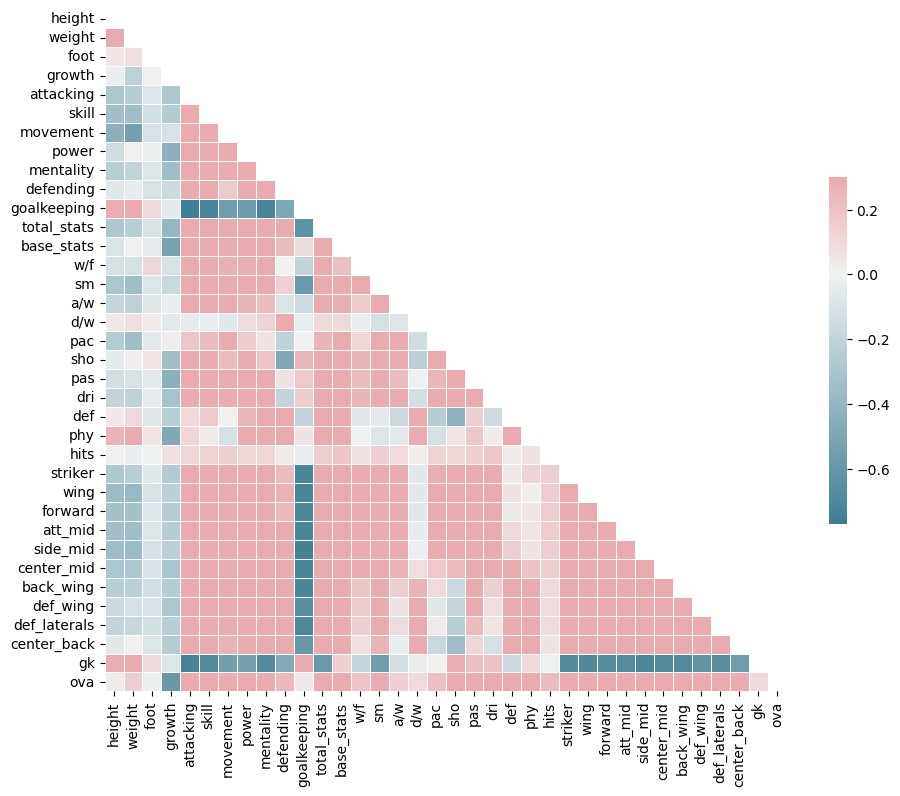

In [305]:
# Compute the correlation matrix

corr=data.corr()

mask=np.triu(np.ones_like(corr, dtype=bool))     # generate a mask for the upper triangle

f, ax=plt.subplots(figsize=(11, 9))                 # set up the matplotlib figure

cmap=sns.diverging_palette(220, 10, as_cmap=True)   # generate a custom diverging colormap

sns.heatmap(corr, mask=mask, cmap=cmap,             # draw the heatmap with the mask and correct aspect ratio
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5});

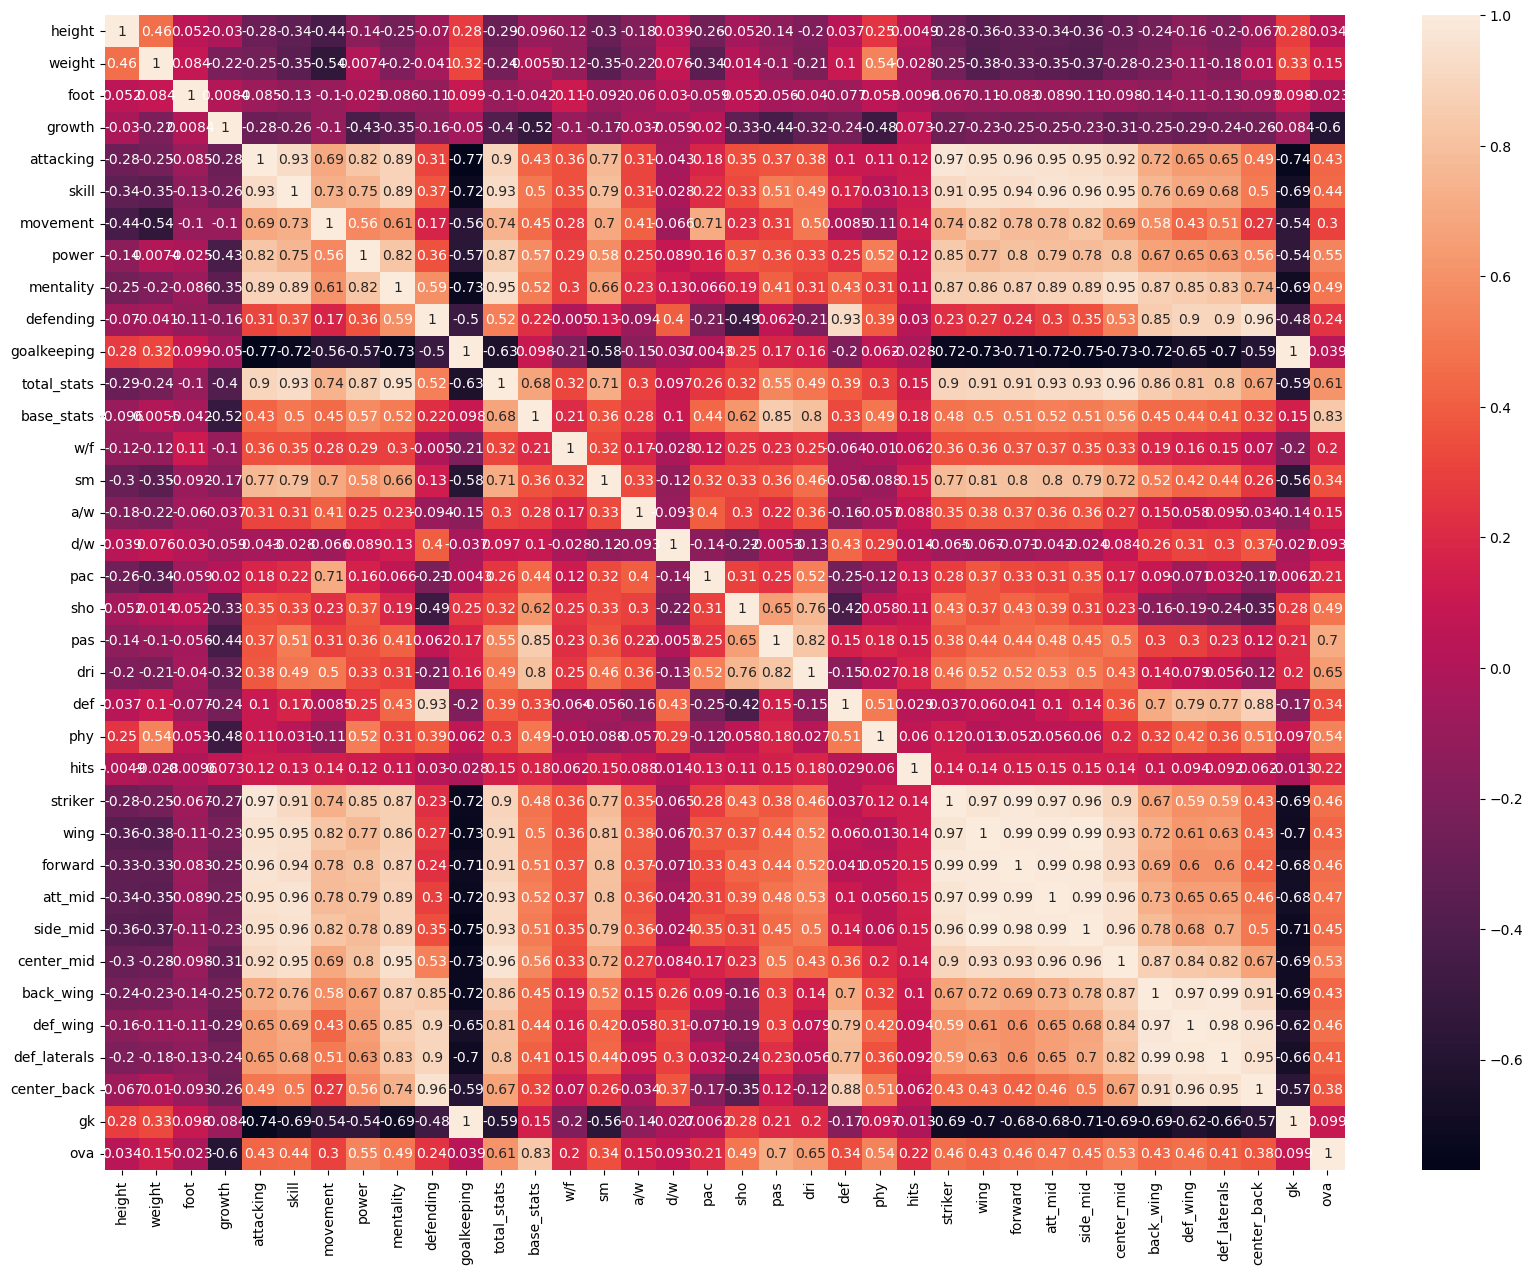

In [306]:
plt.figure(figsize = (20,15))
correlations_matrix = data.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [307]:
# Separate the features from the labels

y = data['ova']
X = data.drop(['ova'], axis=1)

print(f'y: {y.shape}')
print(f'X: {X.shape}')

# Categorical features and numerical ones are going to be treated differently

X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object)

print(f'X_num: {X_num.shape}')
print(f'X_cat: {X_cat.shape}')

# Normalizing data - numerical columns

MinMaxtransformer = MinMaxScaler().fit(X_num)
X_normalized = MinMaxtransformer.transform(X_num)
X_normalized = pd.DataFrame(X_normalized,columns=X_num.columns)

print(f'X_normalized: {X_normalized.shape}')

# Standardizing data - numerical columns

Standardtransformer = StandardScaler().fit(X_num)
X_standardized = Standardtransformer.transform(X_num)
X_standardized = pd.DataFrame(X_standardized,columns=X_num.columns)

# Encoding data - categorical columns

encoder = OneHotEncoder(drop='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()
feature_names = encoder.get_feature_names_out(input_features=X_cat.columns)
onehot_encoded = pd.DataFrame(encoded,columns=feature_names)

print(f'onehot_encoded: {onehot_encoded.shape}')

# Merge numerical & categorical columns

X = pd.concat([X_normalized, onehot_encoded], axis=1)

print(f'X merged: {X.shape}')

# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression

lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
y_pred_lm=lm.predict(X_test)

# Lasso L1

lasso=Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso=lasso.predict(X_test)

# Ridge L2

ridge=Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge=ridge.predict(X_test)

# ElasticNet L1+L2

elastic=ElasticNet()
elastic.fit(X_train, y_train)

y_pred_elastic=elastic.predict(X_test)

# Random forest regressor

rfr=RFR()
rfr.fit(X_train, y_train)

y_pred_rfr=rfr.predict(X_test)

# XGB regressor

xgbr=XGBR()
xgbr.fit(X_train, y_train)

y_pred_xgbr=xgbr.predict(X_test)

# LGBM regressor

lgbmr=LGBMR()
lgbmr.fit(X_train, y_train)

y_pred_lgbmr=lgbmr.predict(X_test)

# Model validation

models=[lm, lasso, ridge, elastic, rfr, xgbr, lgbmr]
model_names=['lm', 'lasso', 'ridge', 'elastic', 'rfr', 'xgbr', 'lgbmr']
preds=[y_pred_lm, y_pred_lasso, y_pred_ridge, y_pred_elastic, y_pred_rfr, y_pred_xgbr, y_pred_lgbmr]

for i in range(len(models)):
    print('=====================================')
    # R2 validation
    train_score=models[i].score(X_train, y_train)
    test_score=models[i].score(X_test, y_test)
    print ('Model: {}, train R2: {} -- test R2: {}'.format(model_names[i], train_score, test_score))
    
    predictions = models[i].predict(X_train)
    
    # MSE validation
    train_mse=mean_squared_error(predictions, y_train)
    test_mse=mean_squared_error(preds[i], y_test)
    print ('Model: {}, train MSE: {} -- test MSE: {}'.format(model_names[i], train_mse, test_mse))

    # RMSE validation
    train_rmse=mean_squared_error(predictions, y_train)**0.5
    test_rmse=mean_squared_error(preds[i], y_test)**0.5
    print ('Model: {}, train RMSE: {} -- test RMSE: {}'.format(model_names[i], train_rmse, test_rmse))

    # MAE validation
    train_mae=mean_absolute_error(predictions, y_train)
    test_mae=mean_absolute_error(preds[i], y_test)
    print ('Model: {}, train MAE: {} -- test MAE: {}'.format(model_names[i], train_mae, test_mae))

y: (11701,)
X: (11701, 36)
X_num: (11701, 35)
X_cat: (11701, 1)
X_normalized: (11701, 35)
onehot_encoded: (11701, 14)
X merged: (11701, 49)


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model: lm, train R2: 0.8799326511759399 -- test R2: 0.8776366833581448
Model: lm, train MSE: 5.66964605900377 -- test MSE: 5.793970443190077
Model: lm, train RMSE: 2.3811018581748598 -- test RMSE: 2.407066771651771
Model: lm, train MAE: 1.8283842925560592 -- test MAE: 1.8186270400457565
Model: lasso, train R2: 0.0 -- test R2: -0.0039448074450259
Model: lasso, train MSE: 47.22054842163416 -- test MSE: 47.537339625697506
Model: lasso, train RMSE: 6.871720921402015 -- test RMSE: 6.894732745052378
Model: lasso, train MAE: 5.46024702772299 -- test MAE: 5.514686953489816
Model: ridge, train R2: 0.8770485036030469 -- test R2: 0.8747701461538083
Model: ridge, train MSE: 5.805837089124703 -- test MSE: 5.929702558762279
Model: ridge, train RMSE: 2.409530470677784 -- test RMSE: 2.4350980593730265
Model: ridge, train MAE: 1.8571710744156797 -- test MAE: 1.8385193998496998
Model: elastic, train R2: 0.08958454148445949 -- test R2: 0.08720366338455177
Model: elastic, train MSE: 42.990317242637346 -- 

In [308]:
# Validation of R2 Scores

print('=====================================')

print(f'X_train / y_train: {lm.score(X_train, y_train)}')
print(f'X_test / y_test: {lm.score(X_test, y_test)}')

# Score on X_train prediction

print('=====================================')

predictions = lm.predict(X_train)
r2_score_x_train = r2_score(y_train, predictions)

print(f'r2_score_x_train: {r2_score_x_train}')

# Score on X_test prediction

predictions_test = lm.predict(X_test)
r2_score_x_test = r2_score(y_test, predictions_test)

print(f'r2_score_x_test: {r2_score_x_test}')

# Mean squared error

mse=mean_squared_error(y_test,predictions_test)

print(f'mse: {mse}')

# Squared of mean squared error

rmse = np.sqrt(mean_squared_error(y_test,predictions_test))

print(f'rmse: {rmse}')

X_train / y_train: 0.8799326511759399
X_test / y_test: 0.8776366833581448
r2_score_x_train: 0.8799326511759399
r2_score_x_test: 0.8776366833581448
mse: 5.793970443190077
rmse: 2.407066771651771


In [309]:
# Load new data

data_for_p = pd.read_csv('fifa21_validate.csv')
data_for_p.shape

(1999, 101)

In [310]:
# Preprocess new data

data_for_p = preprocess(data_for_p)
data_for_p.shape

(1999, 37)

In [311]:
# Separate the features from the labels

y_for_p = data['ova']
X_for_p = data.drop(['ova'], axis=1)

print(f'y_for_p: {y_for_p.shape}')
print(f'X_for_p: {X_for_p.shape}')

# Categorical features and numerical ones are going to be treated differently

X_for_p_num = X_for_p.select_dtypes(include = np.number)
X_for_p_cat = X_for_p.select_dtypes(include = object)

print(f'X_for_p_num: {X_for_p_num.shape}')
print(f'X_for_p_cat: {X_for_p_cat.shape}')

# Normalizing data - numerical columns

X_for_p_normalized = MinMaxtransformer.transform(X_for_p_num)
X_for_p_normalized = pd.DataFrame(X_for_p_normalized,columns=X_for_p_num.columns)

# Encoding data - categorical columns

encoded_for_p = encoder.transform(X_for_p_cat).toarray()
feature_names_for_p = encoder.get_feature_names_out(input_features=X_for_p_cat.columns)
onehot_encoded_for_p = pd.DataFrame(encoded_for_p, columns=feature_names_for_p)

# Merge numerical & categorical columns

X_for_p = pd.concat([X_for_p_normalized, onehot_encoded_for_p], axis=1)

# Predict & inspect results (using linear regression)

results_for_p = lm.predict(X_for_p)
pd.concat([data_for_p,pd.Series(results_for_p, name='estimate')],axis=1).head()

y_for_p: (11701,)
X_for_p: (11701, 36)
X_for_p_num: (11701, 35)
X_for_p_cat: (11701, 1)


bp  height  weight  foot  growth  attacking  skill  movement  power  \
0   CB   189.0    88.0   1.0     7.0      230.0  228.0     303.0  288.0   
1  CAM   176.8    69.9   1.0     5.0      298.0  330.0     375.0  323.0   
2   GK   189.0    79.8   1.0    17.0       48.0   52.0     165.0  171.0   
3  CDM   192.0    77.1   1.0    23.0      215.0  224.0     275.0  242.0   
4  CDM   189.0    77.1   1.0     5.0      295.0  327.0     320.0  337.0   

   mentality  ...  att_mid  side_mid  center_mid  back_wing  def_wing  \
0      246.0  ...     50.0      52.0        53.0       61.0      63.0   
1      286.0  ...     70.0      69.0        63.0       51.0      49.0   
2       76.0  ...     19.0      18.0        20.0       18.0      20.0   
3      230.0  ...     49.0      51.0        51.0       55.0      56.0   
4      314.0  ...     70.0      69.0        72.0       72.0      74.0   

   def_laterals  center_back    gk   ova   estimate  
0          63.0         69.0  18.0  67.0  63.001545  
1          47.0         40.0  19.0  68.0  77.402455  
2          18.0         20.0  55.0  54.0  75.160336  
3          55.0         56.0  13.0  55.0  60.328704  
4          71.0         70.0  20.0  70.0  65.971115  

[5 rows x 38 columns]